In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.special import ndtri
from scipy.optimize import curve_fit
from scipy.stats import binom
sns.set(rc={'figure.figsize': (15, 6)})
%config InlineBackend.figure_format = 'retina'

# Assignment 1

Topics: Signal detection theory, psychometric function, magnitude perception

Group Members: Mikkel s184230, Benjamin s184198, Orfeas s212584

## Equal variance model exercise - **Responsible: Benjamin**

In [ ]:
from dataclasses import dataclass, astuple, asdict
from scipy.special import ndtri

@dataclass
class Experiment:
    bias: str
    tp: int
    fp: int
    n: int # experience number

@dataclass
class EqualVarianceModel:
    c: float = 0.5 # response criterion
    sd: float = 1 # sigma aka. standard deviation
    s_mean: float = 1
    s0_mean: float = 0

    # freeze distributions
    s = norm(loc = s_mean, scale = sd)
    s0 = norm(loc = s0_mean, scale = sd)

    d = s_mean # perceptual sensitivity

    def plot(self):
        fig, ax = plt.subplots(figsize=(8,4))

        x = np.linspace(self.s0.ppf(0.01), self.s.ppf(0.99), 1000)

        plt.axvline(x = self.c, color = 'b', label = 'response criterion')
        ax.plot(x, self.s.pdf(x), 'k-', lw=2)
        ax.plot(x, self.s0.pdf(x), 'k-', lw=2)

        # false negative
        plt.fill_between(x, self.s.pdf(x), where = (x < self.c), color = 'darkgray')

        # false positive
        plt.fill_between(x, self.s0.pdf(x), where = (self.c <= x), color = 'lightgray')

        plt.legend()
        plt.show()

    def response_probs(self):
        return {
            'tp': 1 - self.s.cdf(self.c),
            'fp': 1 - self.s0.cdf(self.c),
            'tn': self.s0.cdf(self.c),
            'fn': self.s.cdf(self.c)
            }


    def simulate(self, s_trials = 50, s0_trials = 50):
        # simulate responses
        # todo: update the simulate function
        probs = self.response_probs()
        s_result = [i for i in range(s_trials)]
        s0_result = [i for i in range(s0_trials)]
        for i in range(s_trials):
            s_result[i] = np.random.choice(['tp', 'fn'], p=[probs['tp'], probs['fn']])
        for i in range(s0_trials):
            s0_result[i] = np.random.choice(['tn', 'fp'], p=[probs['tn'], probs['fp']])
        return np.array(s_result + s0_result)

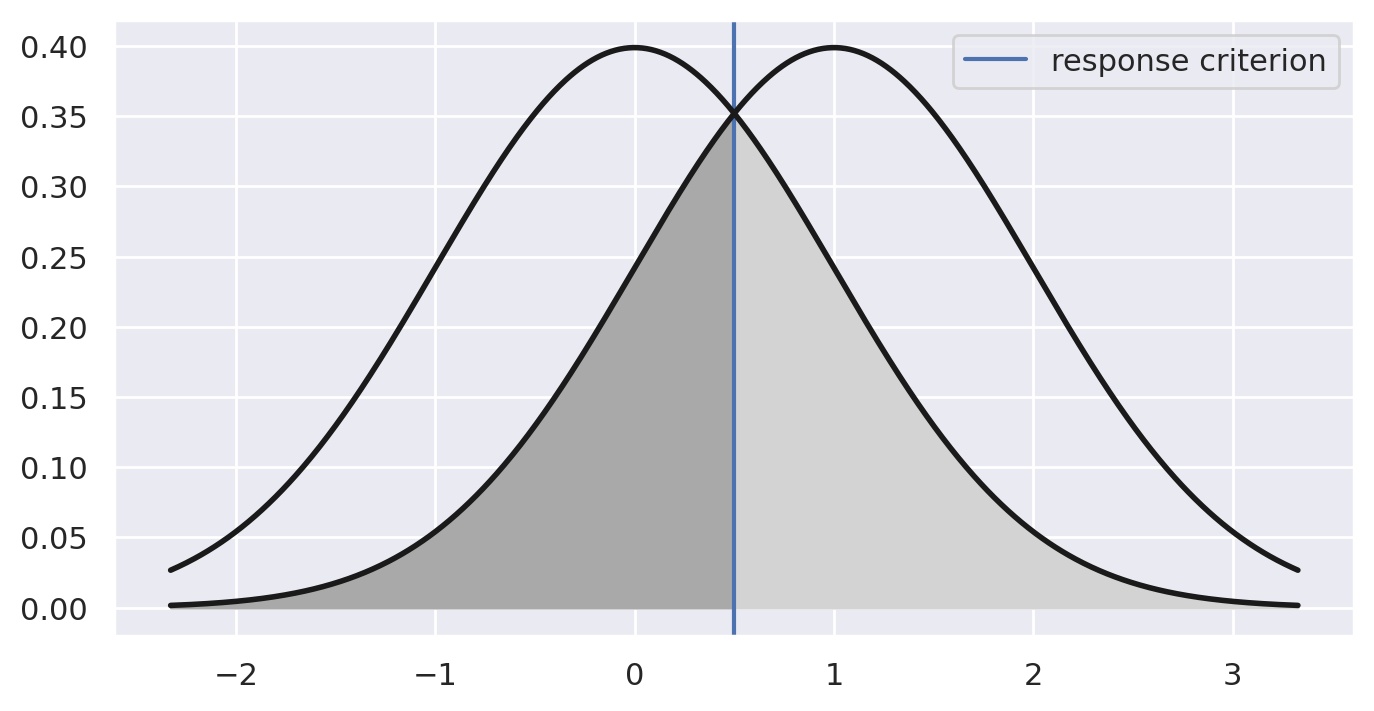

In [ ]:
# visualize the model
example = EqualVarianceModel()
example.plot()

Lower values of the response criterion $c$ indicates that the observer is more likely to say yes. Thus, we have fewer false negatives. perceptual sensitivity $d$ is low for elderly people, they don’t hear well (and high for young people, they hear :ear: well xD)

Simulate responses from 100 experiments with 3 observers each doing 50 trials containing a stimulus and 50 trials containing no stimulus. All three observers behave according to the equal variance model and have a perceptual sensitivity of d′ = 1 but they have different response criteria: One observer is biased towards ’yes’-responses, one is biased towards ’no’-responses, and one is not very strongly biased towards ’yes’- or ’no’-responses.

In [ ]:
# todo: simulate 3 observers
obs_yes = EqualVarianceModel(1.0, 1)
obs_unbiased = EqualVarianceModel()
obs_no = EqualVarianceModel(0.0, 1)

# simulate response experiments
s_trials = 50
s0_trials = 50
experiments = 100
result_equal_variance = pd.DataFrame()
for i in range(experiments):
    
    responses = obs_yes.simulate(s_trials,s0_trials)
    yes_ex = (responses == 'tp').sum(), (responses == 'fp').sum(), i

    responses = obs_unbiased.simulate(s_trials,s0_trials)
    unbiased_ex = (responses == 'tp').sum(), (responses == 'fp').sum(), i

    responses = obs_no.simulate(s_trials,s0_trials)
    no_ex = (responses == 'tp').sum(), (responses == 'fp').sum(), i

    experiment = pd.DataFrame([
        Experiment('yes', *yes_ex),
        Experiment('unbiased', *unbiased_ex),
        Experiment('no', *no_ex)
    ])
    result_equal_variance = pd.concat([result_equal_variance, experiment], ignore_index=True)
result_equal_variance.head(5)

,bias,tp,fp,n
0,yes,22,3,0
1,unbiased,34,10,0
2,no,44,24,0
3,yes,26,7,1
4,unbiased,34,13,1


For each experiment and each observer. Plot the distribution of the perceptual sensitivity across trials for each of the three observers. Are the distributions centered around the correct estimate for d′ each of the three simulated data sets?

In [ ]:
def get_perceptual_sensitivity(n_tp, n_fp, N_s):
    """
    n_tp: the number of true positive responses
    n_fp: the number of false positive responses
    N_s: the number of trials in which a stimulus was presented
    """ 
    d = ndtri(n_tp / N_s) - ndtri(n_fp / N_s)
    return d

In [ ]:
# todo: plot experiments for each observer
result_equal_variance['d_prime'] = result_equal_variance.apply(lambda row : get_perceptual_sensitivity(row['tp'],row['fp'],50), axis=1)

<Figure size 1080x432 with 0 Axes>

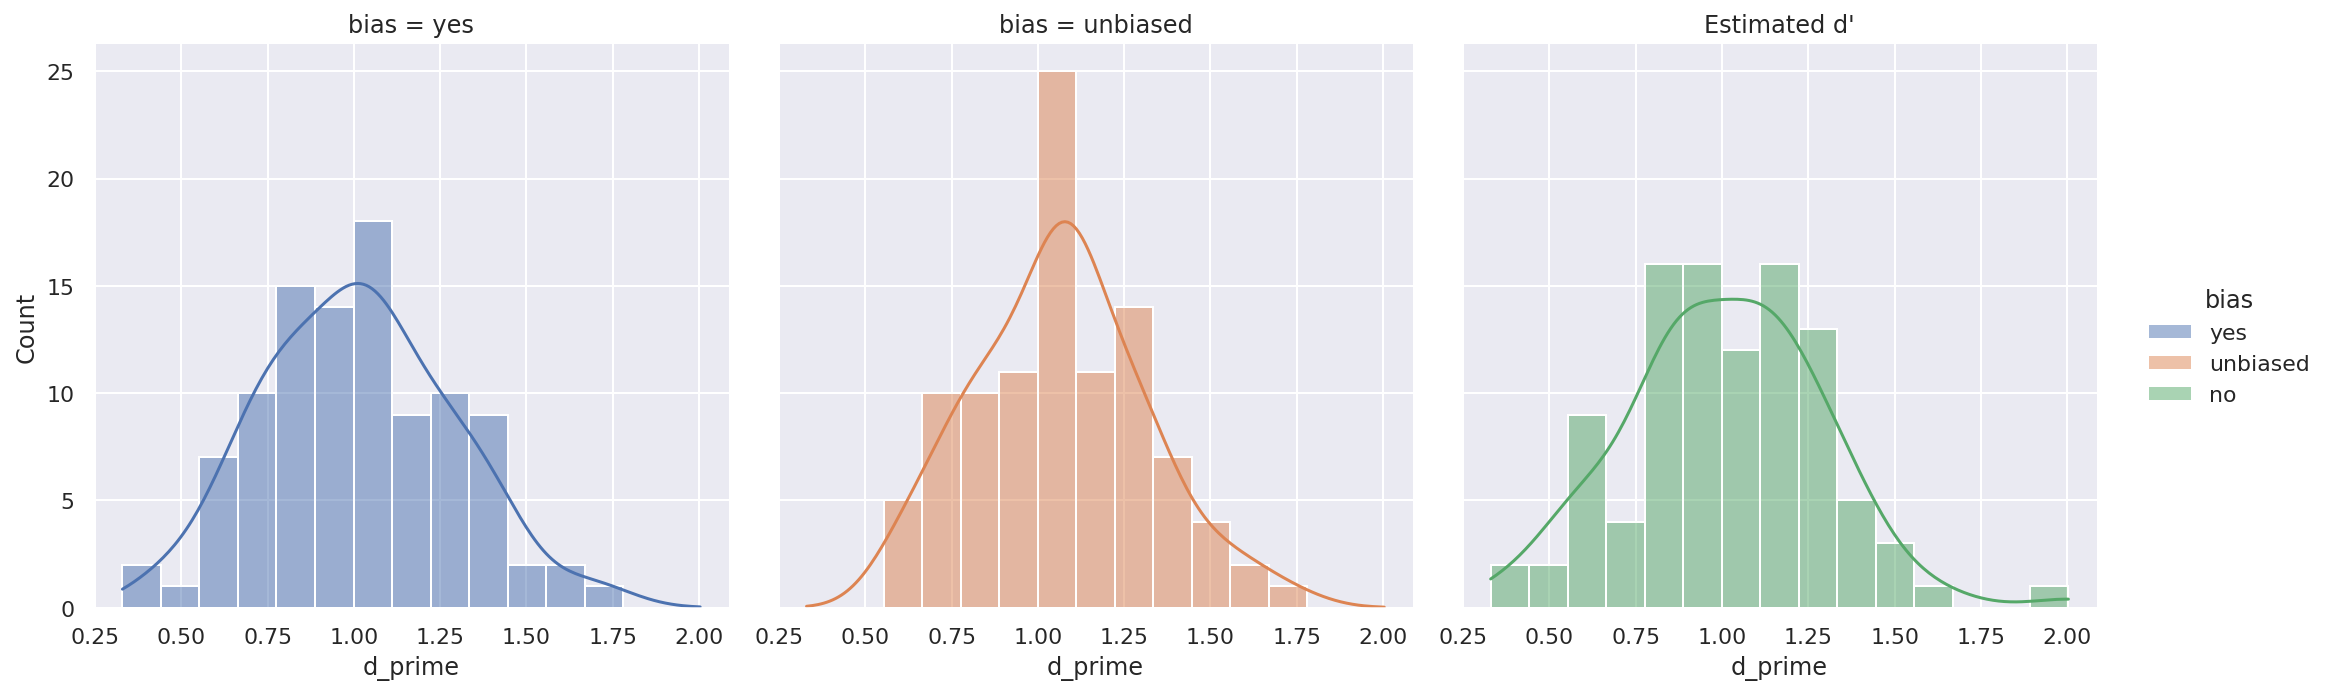

In [ ]:
plt.figure()
g = sns.displot(data=result_equal_variance, x="d_prime", col="bias", hue="bias",kde=True)
#plt.title("Estimated d'")
plt.show()

## Unequal variance model exercise

In [ ]:
from dataclasses import dataclass, astuple, asdict
from scipy.special import ndtri

@dataclass
class UnequalVarianceModel:
    c: float = 0.5 # response criterion

    # distribution parameters
    s_sd: float = 1 # sigma aka. standard deviation
    s0_sd: float = 1
    s_mean: float = 1 # perceptual sensitivity
    s0_mean: float = 0

    # freeze distributions
    s = norm(loc = s_mean, scale = s_sd)
    s0 = norm(loc = s0_mean, scale = s0_sd)

    def response_probs(self):
        return {
            'tp': 1 - self.s.cdf(self.c),
            'fp': 1 - self.s0.cdf(self.c),
            'tn': self.s0.cdf(self.c),
            'fn': self.s.cdf(self.c)
        }
    
    def simulate(self, trials = 50):
        # simulate responses
        probs = self.response_probs()
        result = np.random.choice(['stimulus', 'non-stimulus'], trials)
        for i, r in enumerate(result):
            if r == 'stimulus':
                result[i] = np.random.choice(['tp', 'fn'], p=[probs['tp'], probs['fn']])
            if r == 'non-stimulus':
                result[i] = np.random.choice(['tn', 'fp'], p=[probs['tn'], probs['fp']])
        return result

    def plot(self):
        fig, ax = plt.subplots(figsize=(8,4))

        x = np.linspace(self.s0.ppf(0.01), self.s.ppf(0.99), 1000)

        plt.axvline(x = self.c, color = 'b', label = 'response criterion')
        ax.plot(x, self.s.pdf(x), 'k-', lw=2)
        ax.plot(x, self.s0.pdf(x), 'k-', lw=2)

        # false negative
        plt.fill_between(x, self.s.pdf(x), where = (x < self.c), color = 'darkgray')

        # false positive
        plt.fill_between(x, self.s0.pdf(x), where = (self.c <= x), color = 'lightgray')

        plt.legend()
        plt.show()

From 100 experiments with 3 observers each doing 50 trials. All three observers
behave according to the unequal variance model and have a perceptual sensitivity of mus = 1 and
σ = 0.8 but they have different response criteria: One observer is biased towards ’yes’-responses, one is
biased towards ’no’-responses, and one is not very strongly biased towards ’yes’- or no-responses.

In [ ]:
# defining the observers
obs_yes = UnequalVarianceModel(0.05, 0.8, 0.8)
obs_unbiased = UnequalVarianceModel(0.5, 0.8, 0.8)
obs_no = UnequalVarianceModel(0.95, 0.8, 0.8)

# simulate response experiments
trials = 50
result_unequal_variance = pd.DataFrame()
for i in range(100):
    
    responses = obs_yes.simulate(trials)
    yes_ex = (responses == 'tp').sum(), (responses == 'fp').sum(), i

    responses = obs_unbiased.simulate(trials)
    unbiased_ex = (responses == 'tp').sum(), (responses == 'fp').sum(), i

    responses = obs_no.simulate(trials)
    no_ex = (responses == 'tp').sum(), (responses == 'fp').sum(), i

    experiment = pd.DataFrame([
        Experiment('yes', *yes_ex),
        Experiment('unbiased', *unbiased_ex),
        Experiment('no', *no_ex)
    ])
    result_unequal_variance = pd.concat([result_unequal_variance, experiment], ignore_index = True)
result_unequal_variance.head(5)

,bias,tp,fp,n
0,yes,27,10,0
1,unbiased,21,8,0
2,no,15,1,0
3,yes,25,14,1
4,unbiased,11,4,1


In [ ]:
result_unequal_variance['d_prime'] = result_unequal_variance.apply(lambda row : get_perceptual_sensitivity(row['tp'],row['fp'],50), axis=1)

<Figure size 432x288 with 0 Axes>

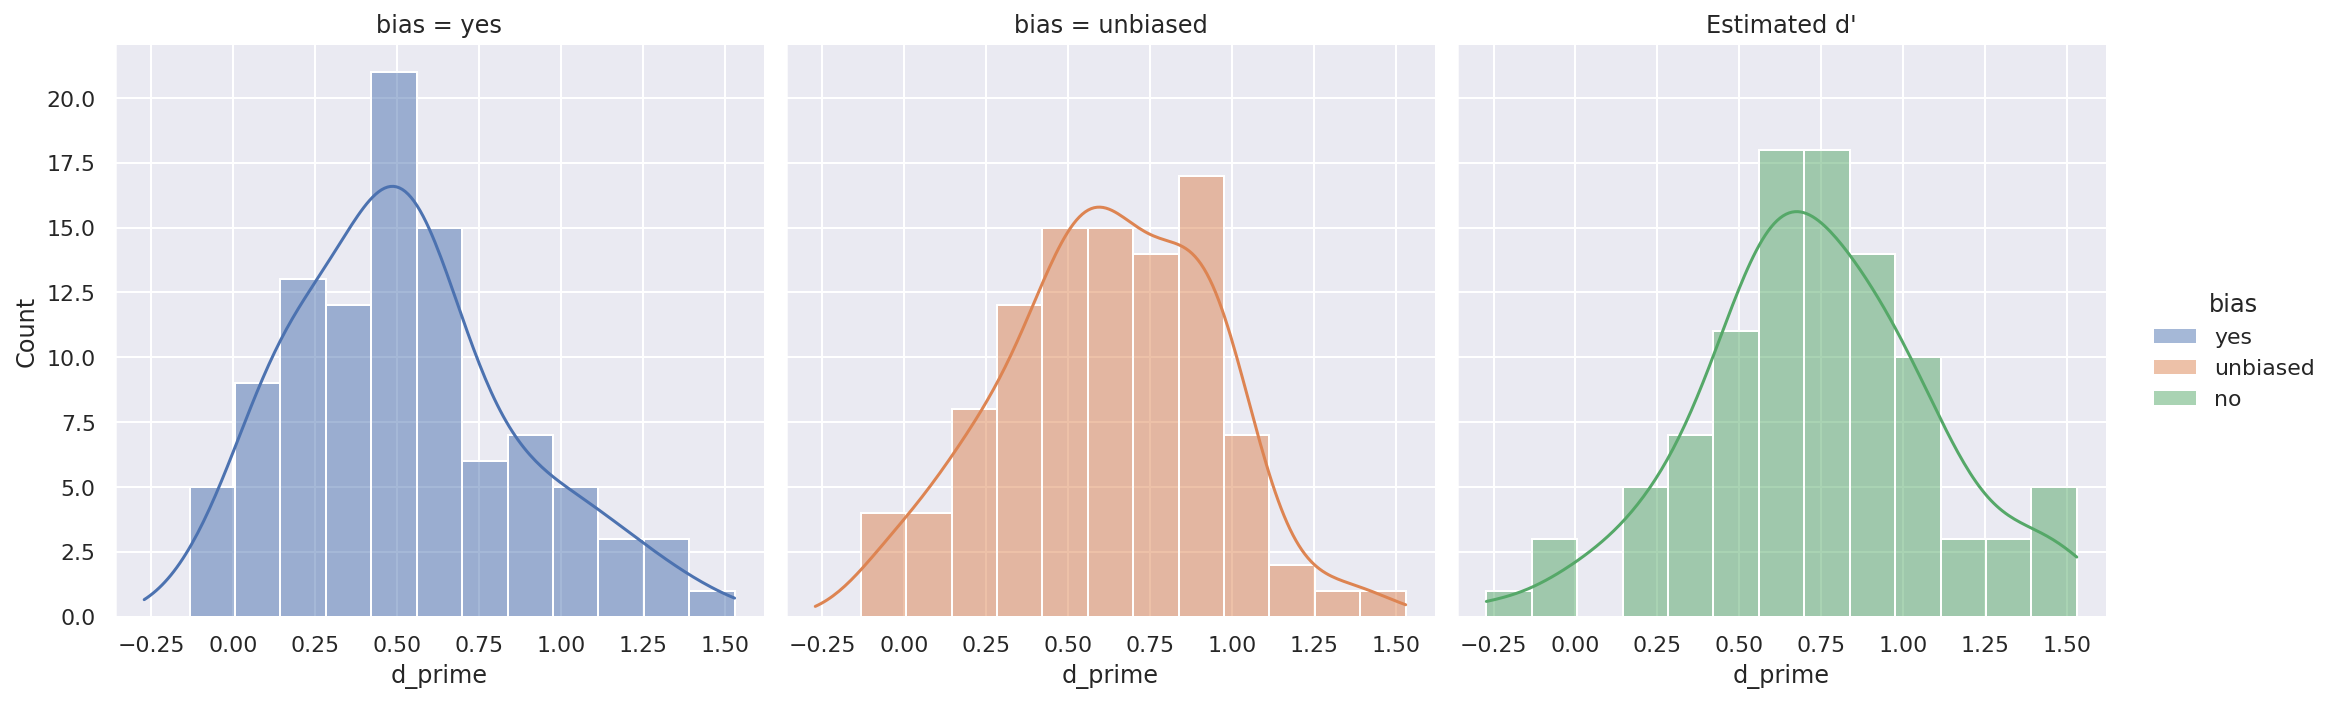

In [ ]:
plt.figure()
g = sns.displot(data=result_unequal_variance, x="d_prime", col="bias", hue="bias",kde=True)
#plt.title("Estimated d'")
plt.show()

## Last Question of equal variance model
Assume that you did not know that the data came from an unequal variance observer and estimate
μs using the equal variance model. Plot the distribution of the perceptual sensitivity across trials for
each of the three observers. Do you get the correct estimate for each of the three simulated data sets?
What are the implications of your results?

#### Answer
We calculate perceptual sensitivity of unequal variance model with equal variance model. Afterwards we compare the perceptual sensitivity of each observer with equal distribution model (sigma_s_0 = sigma_s = 1) with the perceptual sensitivity of unequal distribution model (sigma_s_0 = 1, sigma_s = 2) to see the difference.

50.0


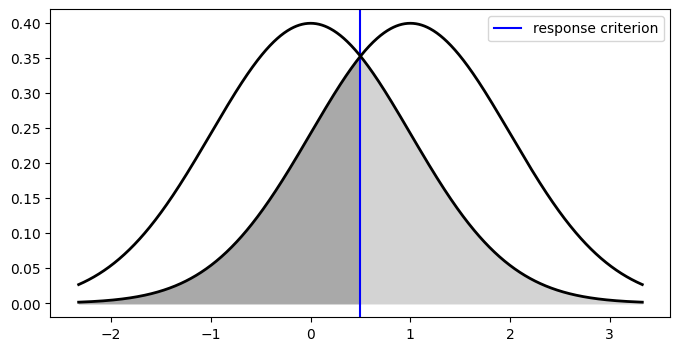

In [ ]:
example2 = EqualVarianceModel(s_mean = 50.0)
print(example2.s_mean)
example2.plot()

In [ ]:
#Calculate perceptual sensitivity (d') for each observer

d_correct = [] # sigma_S = 1
d_incorrect = [] # With sigma_S = 2

for i in range(3):

    tp, fp = simulate_response_v2(1, 50) # With sigma_S = 1
    tp_2, fp_2 = simulate_response_v2(2, 50) # With sigma_S = 2
    N_s = N_s0 = 50

    #mus estimate for sigma_S = 1
    d = ndtri(tp / N_s) - ndtri(fp / N_s0)
    d_correct.append(d)

    #mus estimate for sigma_S = 2
    d_2 = ndtri(tp_2 / N_s) - ndtri(fp_2 / N_s0)
    d_incorrect.append(d_2)

[0.26580531997265733, 0.994457883209753, 0.1659417194568471]
[0.6397277544310633, 0.9443042997450194, 0.8149313673313443]


<AxesSubplot:ylabel='Count'>

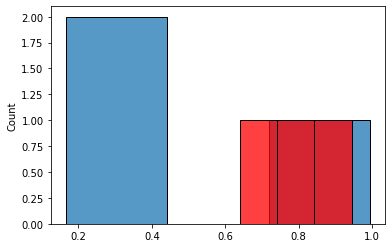

In [ ]:
print(d_correct)
print(d_incorrect)
sns.histplot(d_correct)
sns.histplot(d_incorrect, color = "red")

In [ ]:
deviance = [d_incorrect[i] - d_correct[i] for i in range(3)]
print(deviance)

[0.373922434458406, -0.05015358346473364, 0.6489896478744972]


The plot doesn't provide useful information but from the deviance array we can observe that on some observers the deviance of the incorrect perceptual sensitivity compared to the correct one is huge and in some others observers the deviance is substantially small.

## Psychometric function exercise - **Responsible: Mikkel**

In a 3-alternative classification task, the observer classifies speech sounds under varying sound intensities. The experiment consists of 30 experimental trials at each sound intensity. The sound intensities and the corresponding number of correct responses are shown in the table below.

In [ ]:
trials_n = 30
experiment = pd.DataFrame({
    'Stimulus intensity (dB)': [5,10,15,20,25,30],
    'Number of correct responses': [12,11,19,27,29,29]
})

# proportion of correct responses
experiment['p_correct'] = experiment['Number of correct responses'] / trials_n
experiment

# proportion of correct responses (guess correction)
P_guess = 1/3
experiment['p_correct_tilde'] = (experiment['p_correct'] - P_guess) / (1 - P_guess)

experiment

,Stimulus intensity (dB),Number of correct responses,p_correct,p_correct_tilde
0,5,12,0.400000,0.10
1,10,11,0.366667,0.05
2,15,19,0.633333,0.45
3,20,27,0.900000,0.85
4,25,29,0.966667,0.95
5,30,29,0.966667,0.95


### Fit the high threshold model in Equation $1.12$ and the psychometric function in Equation $1.11$ to the data.

**Psychometric:**
$\Psi\left(I_s\right)=P\left(r=\text { yes } \mid I_s\right)=\Phi\left(\frac{I_s-c}{\sigma}\right)$ (1.11)
Obs ability to perceive stimulus.

**High threshold:**
$P_c\left(I_s\right)=\tilde{P}_c\left(I_s\right)+\left(1-\tilde{P}_c\left(I_s\right)\right) P_{g u e s s}$ (1.12)
Obs inability to perceive cause of fluctuations.

In [ ]:
(N_s - n_s)

0    18
1    19
2    11
3     3
4     0
5     0
Name: Number of correct responses, dtype: int64

In [ ]:
N = 6 * 30
n = experiment['Number of correct responses'].sum()
N_s = 30
n_s = experiment['Number of correct responses']
P_s = experiment['p_correct'] # can be psychometric or hightreshold

# log-likelihood
np.log(np.arange(1, N_s + 1)).sum() - np.array([np.log(np.arange(1, s + 1)).sum() for s in n_s]) - np.log(N - n) + n_s * np.log(P_s) + (N_s - n_s) * np.log(1 - P_s)

0    30.548846
1    33.509370
2    11.671794
3    -3.583617
4          NaN
5          NaN
dtype: float64

In [ ]:
from scipy.optimize import minimize, optimize
from scipy.stats import binom

N_c = 30
P_c = experiment['p_correct']
P_c_tilde = experiment['p_correct_tilde']
n_c = experiment['Number of correct responses']

# cost function
def obj_f(p, k, n):
    return -binom.logpmf(k, n, p).sum()

# x0 can be psychometric or hightreshold
minimize(fun = NLL, x0 = P_c, args = (n_c, N_c))

      fun: 9.121991369806533
 hess_inv: array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])
      jac: array([9.53674316e-07, 1.19209290e-06, 9.53674316e-07, 2.38418579e-06,
       6.91413879e-06, 6.91413879e-06])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.4       , 0.36666667, 0.63333333, 0.9       , 0.96666667,
       0.96666667])

In [ ]:
# define psychometric function
def phychometric(I_s , c = np.mean(I_s), sigma = np.std(I_s)):
    return np.round(norm.cdf((I_s - c)/sigma), 4)

# defined high treshold model
def high_threshold(I_s , N_r = 6, phychometric_function = phychometric(I_s)):
    return np.round( phychometric_function + ((1 - phychometric_function)/N_r), 4)

In [ ]:
#print(phychometric(I_s))
print(high_threshold(I_s))
experiment['phychometric'] = phychometric(I_s)
experiment['high_threshold'] = high_threshold(I_s)

[0.0716 0.1899 0.3848 0.6152 0.8101 0.9284]
[0.2263 0.3249 0.4873 0.6793 0.8418 0.9403]


### Make one plot with the two psychometric functions with and without the data. Estimate which of the two psychometric functions fit data better

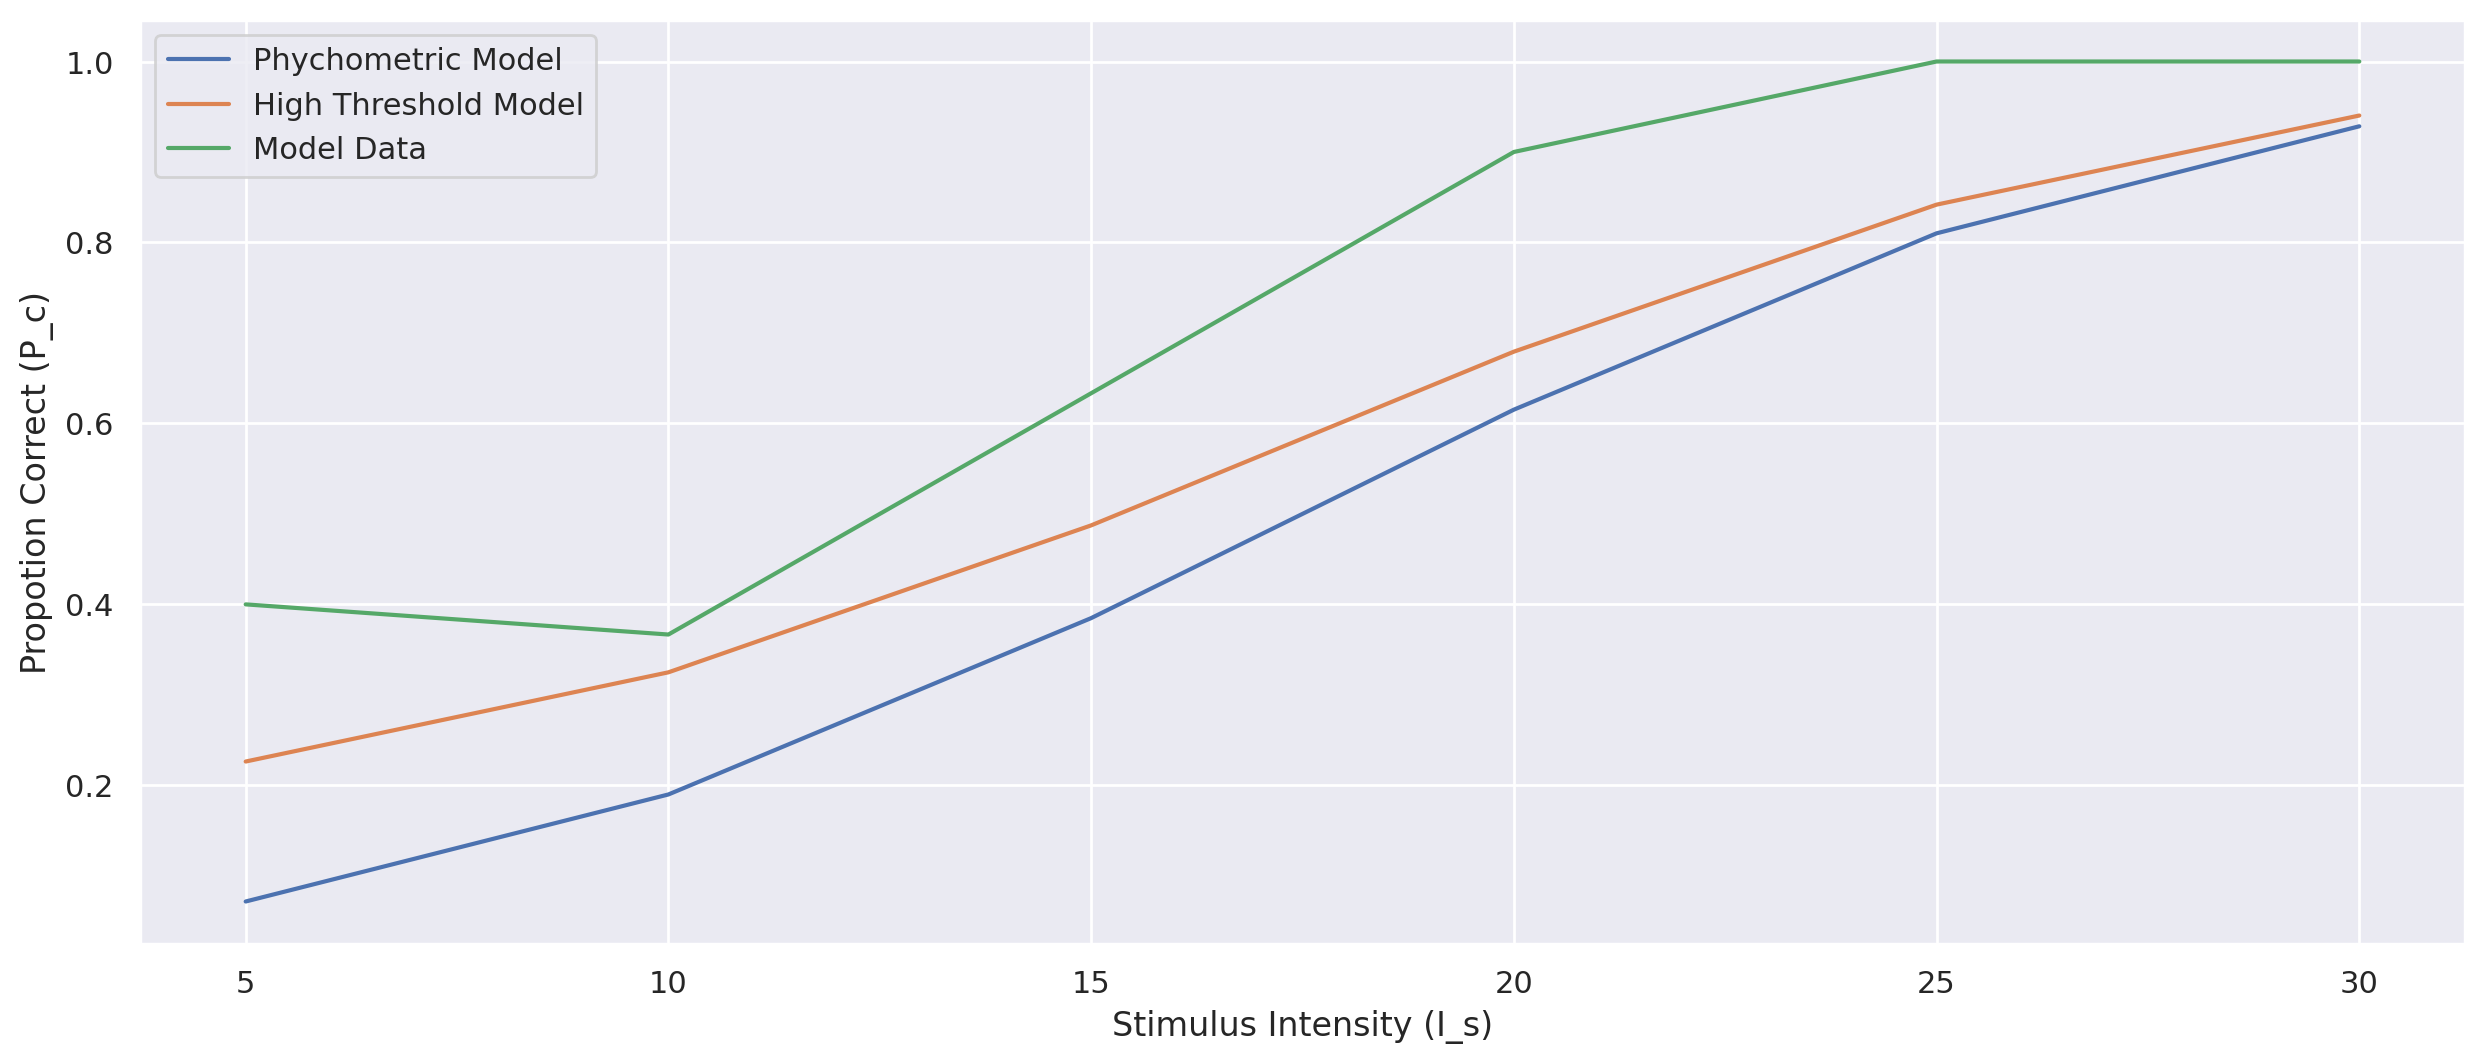

In [ ]:
plt.plot(I_s, phychometric(I_s), label="Phychometric Model") #Blue
plt.plot(I_s, high_threshold(I_s), label="High Threshold Model") #Orange
plt.plot(I_s, p_correct, label="Model Data") #Green
plt.legend(loc='best')
plt.xlabel("Stimulus Intensity (I_s)")
plt.ylabel("Propotion Correct (P_c)")
plt.show()

#### Answer
We can see from the plot the high threshold model fits the data better because it is closer to the real data

### List the value of the negative log likelihood of the two models. Which is lower?

In [ ]:
print(f"Minimum value of negative log likelihood of phychometric model is: { np.around(min(-np.log(phychometric(I_s))), 4)}\n\
Minimum value of negative log likelihood of high threshold model is : {np.around(min(-np.log(high_threshold(I_s))), 4)} ")

Minimum value of negative log likelihood of phychometric model is: 0.0743
Minimum value of negative log likelihood of high threshold model is : 0.0616 


#### Answer
The lowest value of the negative log likelihood between the two models is the one from the high threshold model.

### List the parameter values for each of the two models. Do the two models give similar estimates of the parameter values?

In [ ]:
n_s = experiment['Number of correct responses']
N_s = 6*[30]
P_c = experiment['p_correct']

In [ ]:
def loss_function(P_c):
    return np.round(sum(-binom.logpmf(n_s, N_s, P_c)), 4)

print(f"So the loss of the standard model, phychometric model and high threshold model is respectevily: \n {loss_function(experiment['p_correct']),loss_function(experiment['phychometric']), loss_function(experiment['high_threshold']) }")

So the loss of the standard model, phychometric model and high threshold model is respectevily: 
 (7.1557, 41.0539, 21.9369)


* Answer
The two models seem to have a big difference on their loss functions but the high threshold model seem to approximate the data better that the phychometric function because the error is closer to the actual model.

### Rest of section is try-out code

In [ ]:
# defined high treshold model
def P_c(I_s, N_r, sigma, c):
    p_guess = 1 / N_r
    P_c_tilde = norm.cdf((I_s-c)/sigma)
    return P_c_tilde + (1-P_c_tilde)*p_guess

In [ ]:
# fitting high treshold model to data
import scipy.optimize as optimize
from scipy.stats import binom

# cost function
# ln(L(n_s|sigma, c, s = 0) * L(n_s|sigma, c, s = 1) * L(n_s|sigma, c, s = 2))

# where for stimulus s = {s_0, s_1, s_2}
# L(n_s|sigma, c) = Binomial(N_s = 30, P_s, n_s = n_c)


# to get a column of n_s for each of s
# so sum of n_s for each stimulus per I_s equals N_s


In [ ]:
def negative_log_likelihood(N_s,n_s,P_s):
    N_s = 
    n_s = 
    running_sum = 0
    for i in N_s:
        running_sum = running_sum + math.log(i)
    for i in n_s:
        running_sum = running_sum - math.log(i)
    for i in (N_s-n_s):
        running_sum = running_sum - math.log(i)
    running_sum + n_s * math.log(P_s) + (N_s-n_s) * math.log(P_s)
    return -running_sum

In [ ]:
import scipy.optimize as optimize

def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    a, b, c = params # <-- for readability you may wish to assign names to the component variables
    return a**2 + b**2 + c**2

initial_guess = [1, 1, 1]
result = optimize.minimize(f, initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

In [ ]:
# we only have correct responses
def high_threshold(I_s, P_c, N_r):
    P_guess = 1/N_r
    P_corrected = (P_c - P_guess) / (1 - P_guess)
    return P_corrected
# high_threshold(I_s, P_c, 6);


0    0.28
1    0.24
2    0.56
3    0.88
4    1.00
5    1.00
Name: p_correct, dtype: float64

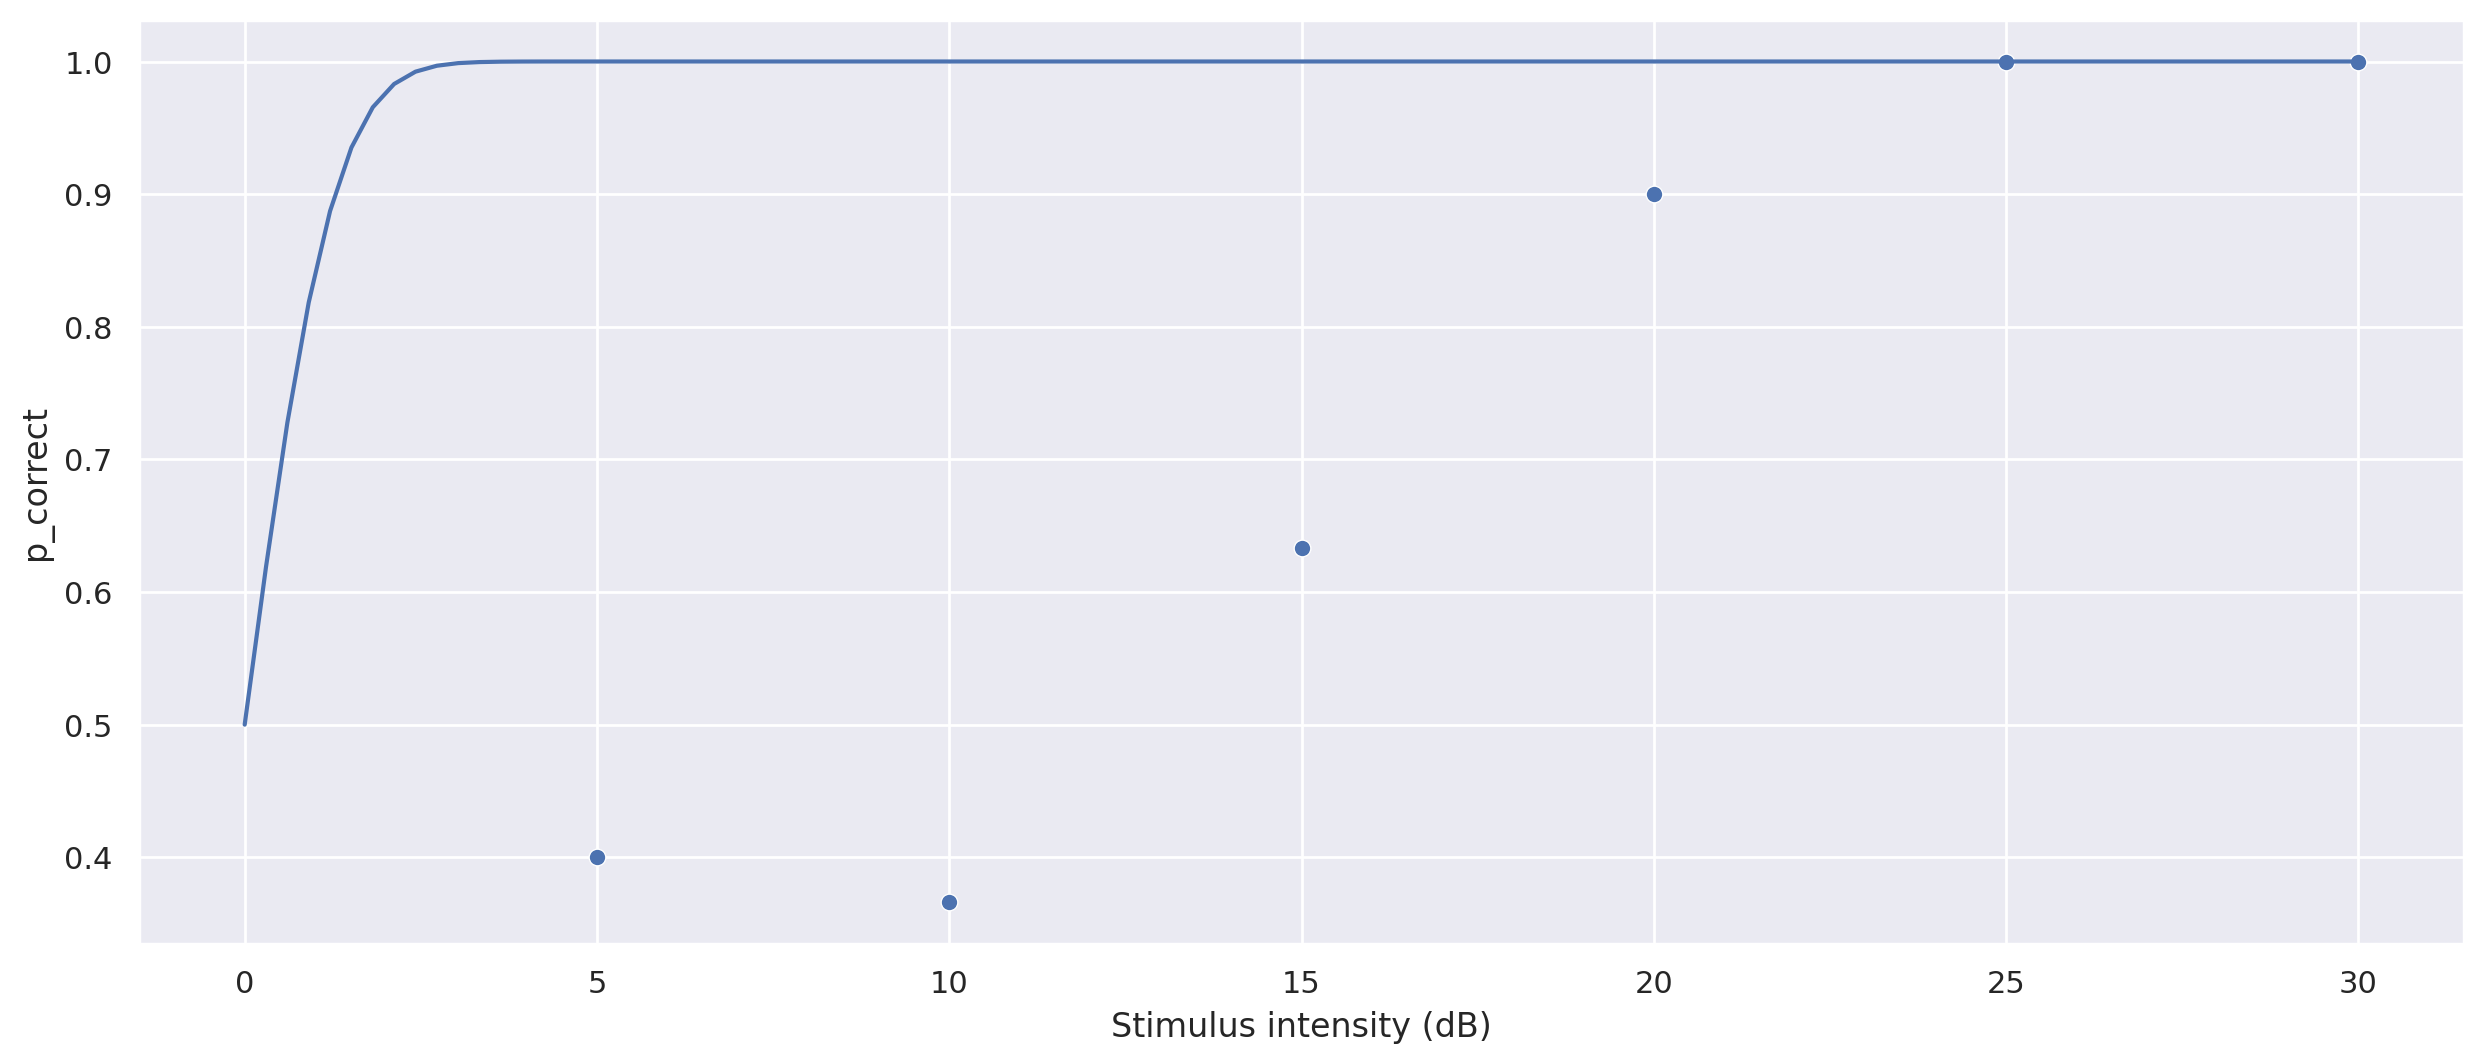

In [ ]:
fig, ax = plt.subplots()

# observed data
sns.scatterplot(data=experiment, x='Stimulus intensity (dB)', y='p_correct');

# gaussian cdf
model = norm(loc = 0, scale = 1)

# plotting psychometric function
#x = np.linspace(0, 30, 100)
#sns.lineplot(x=x, y=model.cdf(x))
#s.cdf(experiment['Stimulus intensity (dB)']) = 0.5

plt.show()

In [ ]:
# perceived stimulus above threshold c
def psychometric(I_s, c, sigma):
    rv = norm()
    # psycho transform
    s = (I_s - c) / sigma
    y = rv.cdf(s)
    return y
psychometric(experiment['Stimulus intensity (dB)'], 0.2, .5)

array([1., 1., 1., 1., 1., 1.])

In [ ]:
from sklearn.metrics import mean_squared_error

# find c and sigma by psychometric = hightreshold (given)
I_s = experiment['Stimulus intensity (dB)']
P_c = experiment['p_correct']

corrected = high_threshold(I_s, P_c, 3)

C = 0
Sigma = 0
difference = np.inf
for c in np.arange(-6,6, 100):
    for sigma in np.arange(-6,6,100):
        psyc = psychometric(I_s, c, sigma)

        d = mean_squared_error(corrected, psyc) #np.abs(psyc - corrected)

        if d < difference:
            difference = d
            C = c
            Sigma = sigma
print(C)
print(Sigma)


-6
-6


In [ ]:
# binomial 
from scipy.stats import binom

fig, ax = plt.subplots()

# model with fitted parameters
rv = 

plt.show()

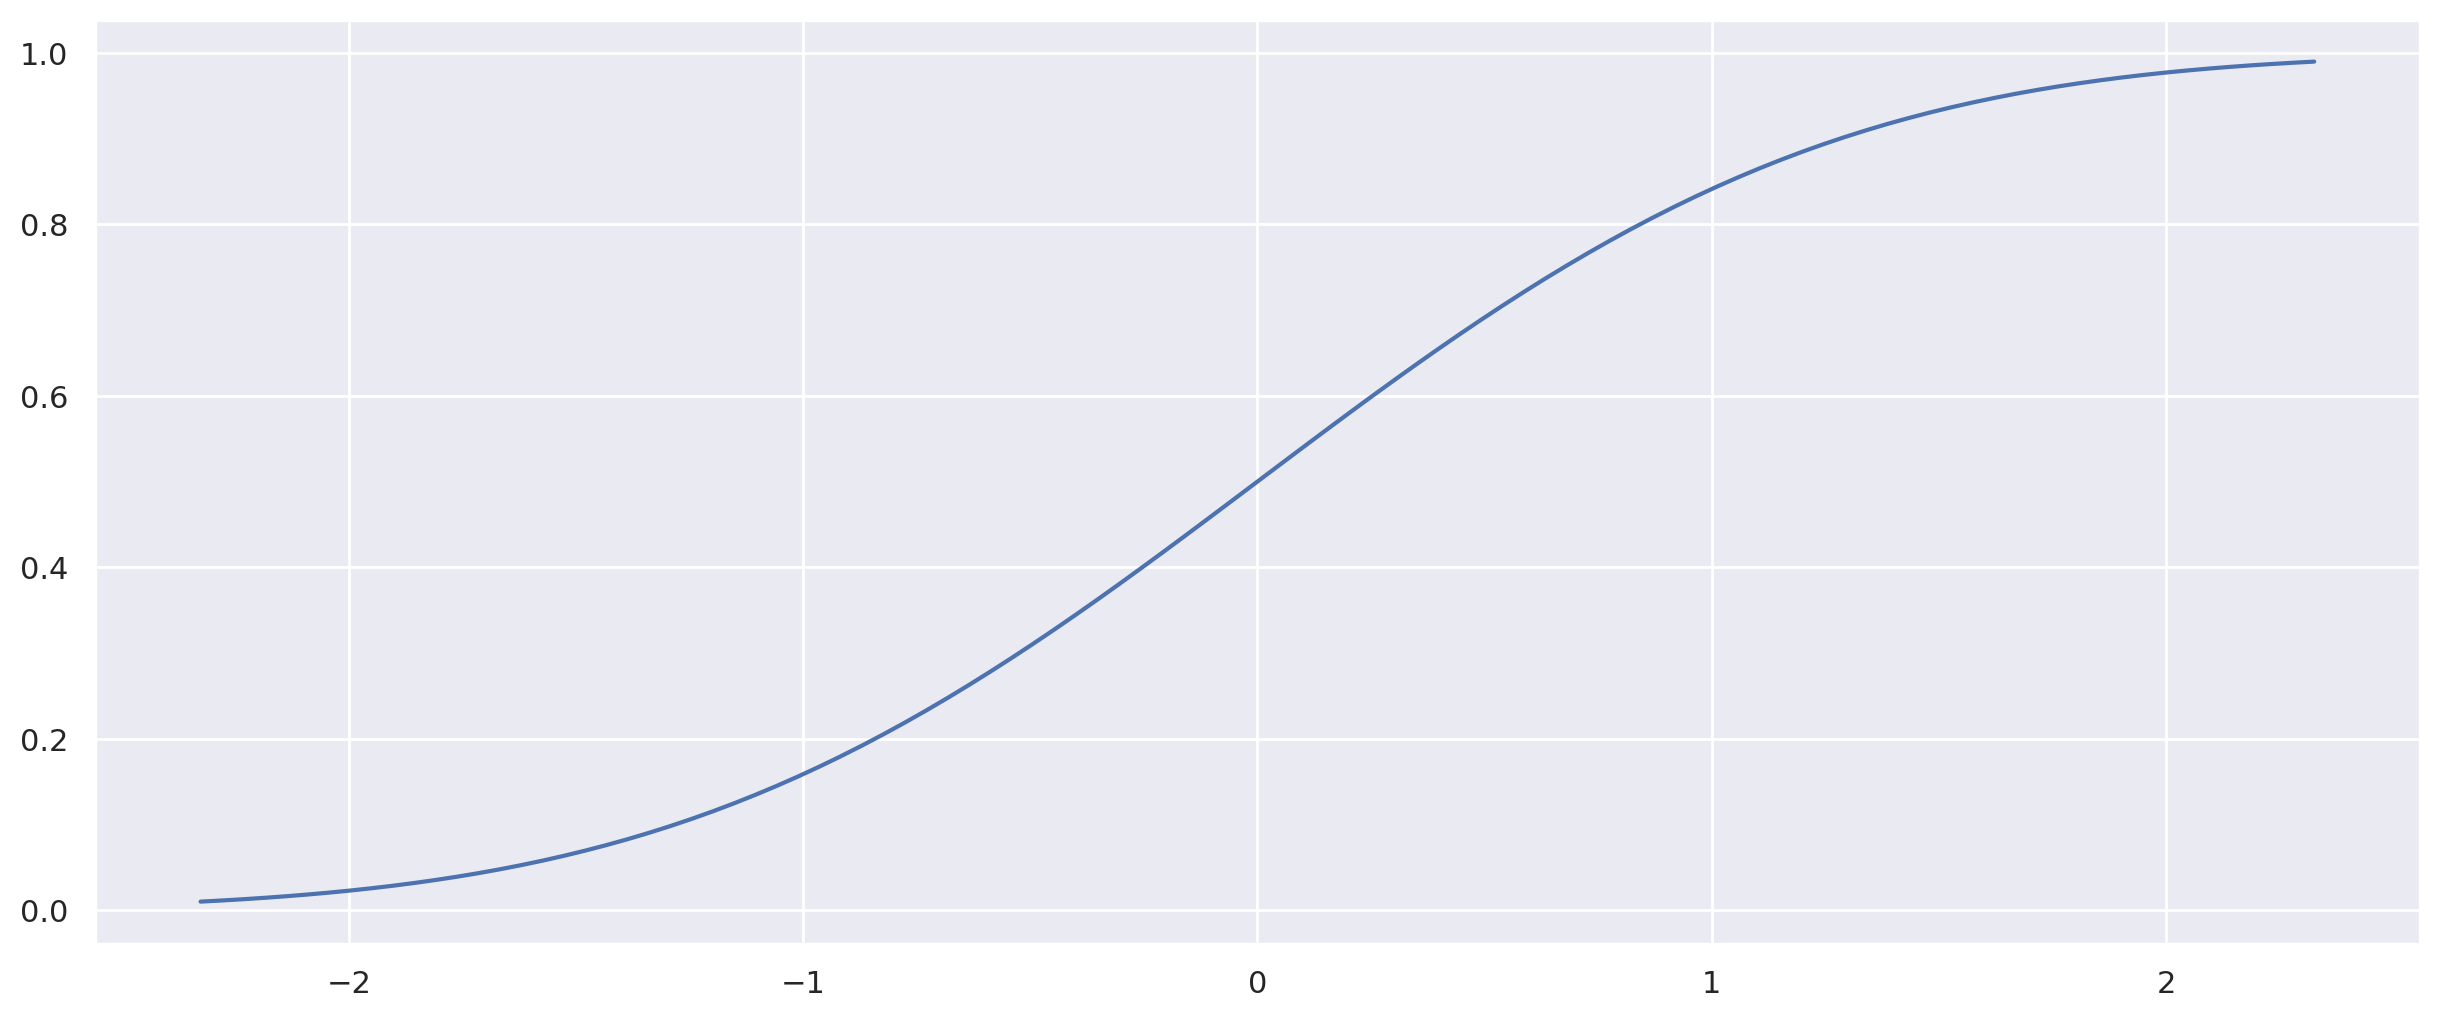

In [ ]:
# plotting psychometric function
fig, ax = plt.subplots()

rv = norm()

x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
y = rv.cdf(x)

sns.lineplot(x=x, y=y)
#s.cdf(experiment['Stimulus intensity (dB)']) = 0.5

plt.show()

In [ ]:
# 
def high_threshold(I_s, N_r = 6):
    p_guess = 1 / N_r

In [ ]:
# 
def psychometric():
    pass

In [ ]:
@dataclass
class PsychometricModel:
    # attributes
    # fit
    # plot

## Magnitude estimation exercise - **Responsible: Orpheus**

Although mathematically different, Fechner and Stevens' laws of perceptual intensity provide fairly good fits to perceived brightness as a function of luminance. This is because the exponent of Stevens' law is approximately $a=0.33<1$ so that
$$
I_p=10 I_s^{0.33}
$$
To see that this relationship might be mistaken for a logarithmic relationship, first calculate the perceived stimulus intensity, $I_p$, for physical intensities $I_s=1,2, \ldots, 10$ using Steven's law. This simulates an observer that rates the perceived intensity according to Stevens' law.

In [ ]:
# simulating the observer using Steven's law
I_s = np.arange(1,11)
I_p = 10 * I_s ** 0.33

### Fit Fechner's law to the simulated data. Note that Fechner's law is linear with respect to $I_s$.

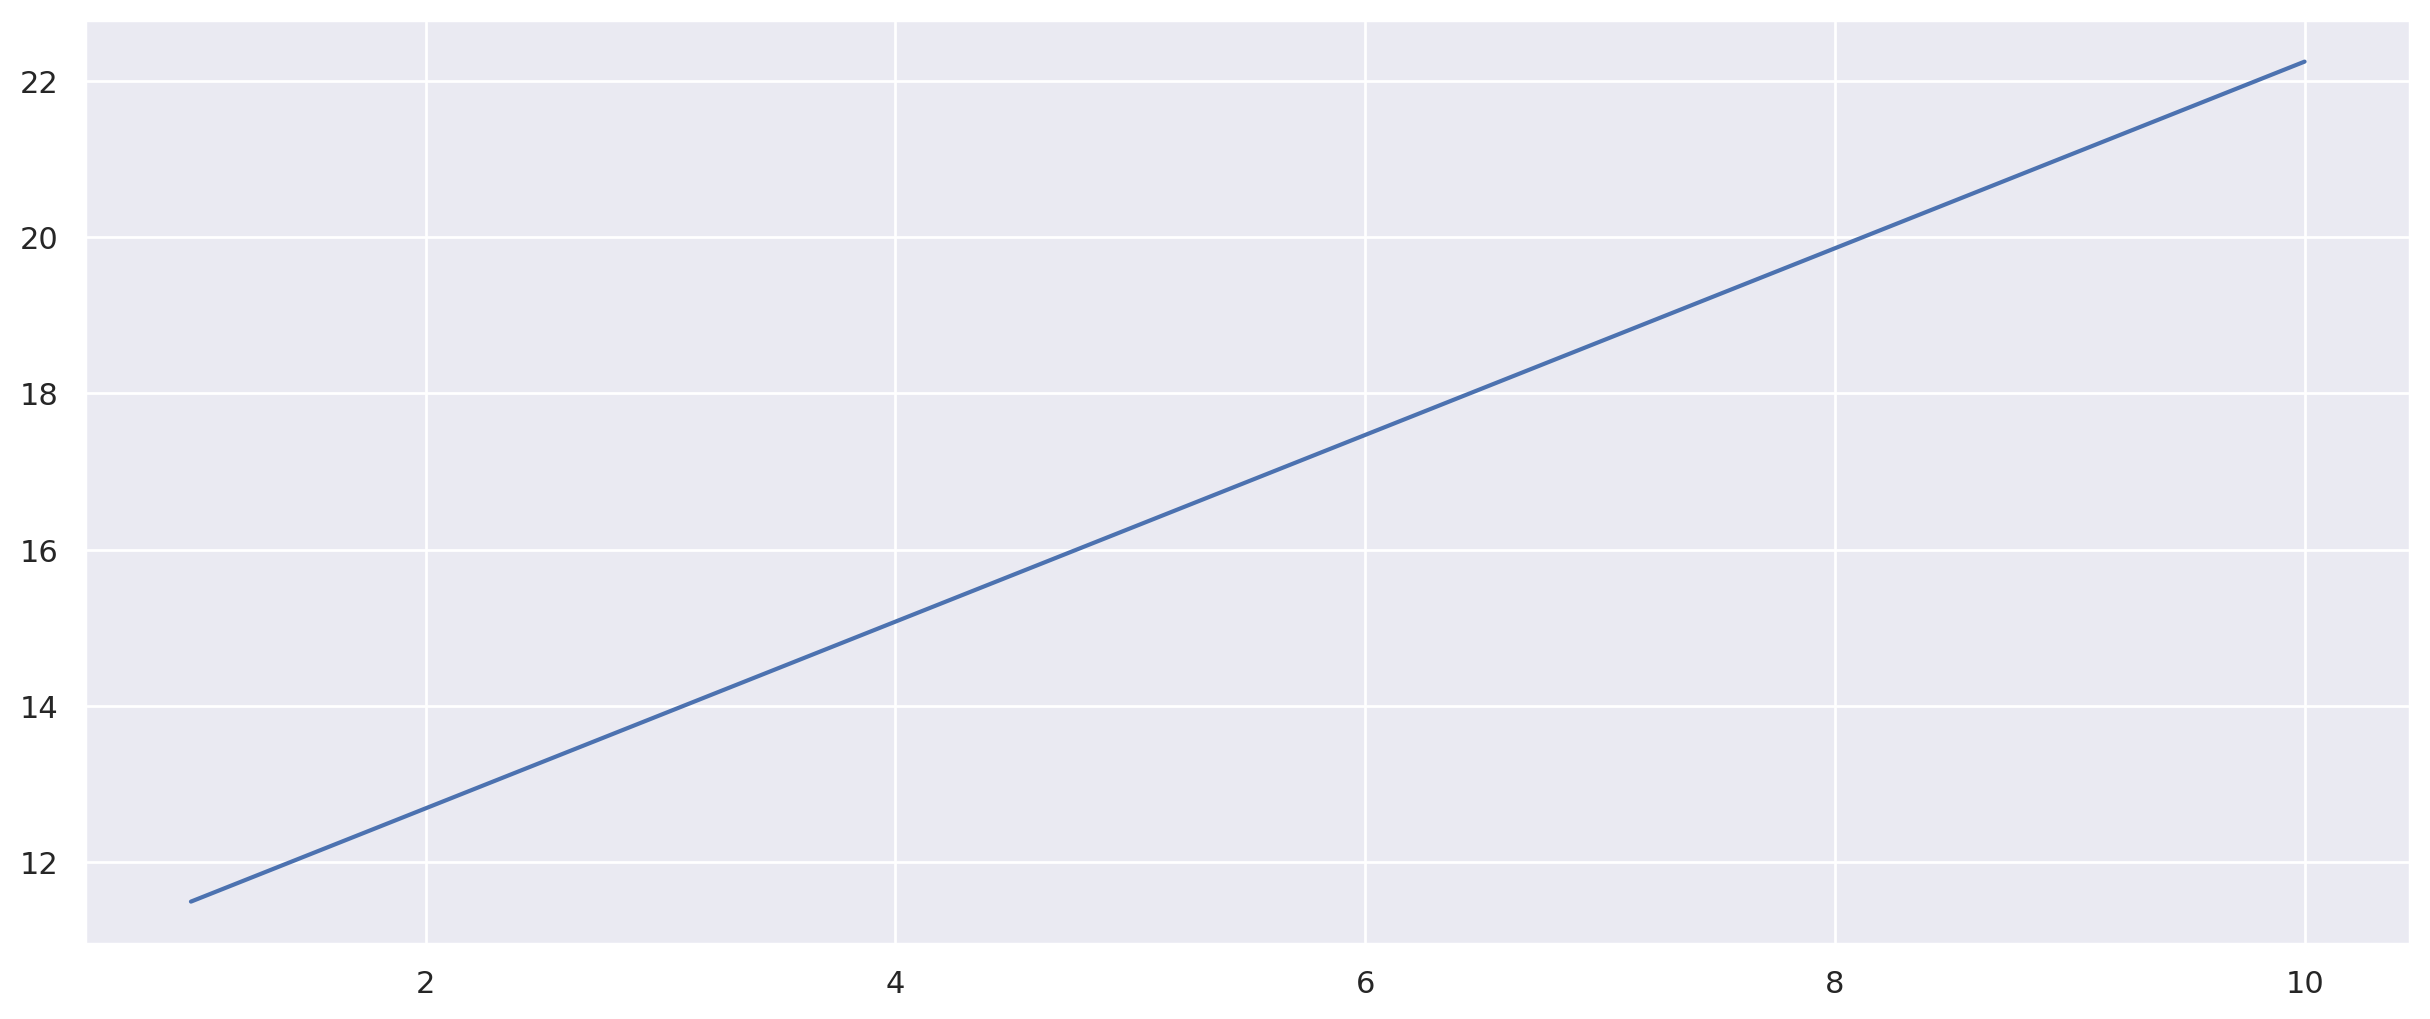

In [ ]:
# fitting straight line to the simulated data
coeffs = np.polyfit(I_s, I_p, 1)

# print 

# computing values
x = np.linspace(1, 10, 100)
y = np.poly1d(coeffs)(x)

# plot I_s

# plotting
plt.plot(x, y)
#plt.xlabel()
#plt.ylabel()
plt.show()

In [ ]:
# defining stevens law
def stevens(I_s, k_s, a):
    I_p = k_s * (I_s ** a)
    return I_p

# defining fechner
def fechner():
    

# given simulation
I_s = np.arange(1,11) # physical intensities
I_p = stevens(I_s, 10, 0.33)
I_p

array([10.        , 12.57013375, 14.36977652, 15.80082624, 17.00826843,
       18.06300128, 19.00563363, 19.86184991, 20.64904773, 21.3796209 ])

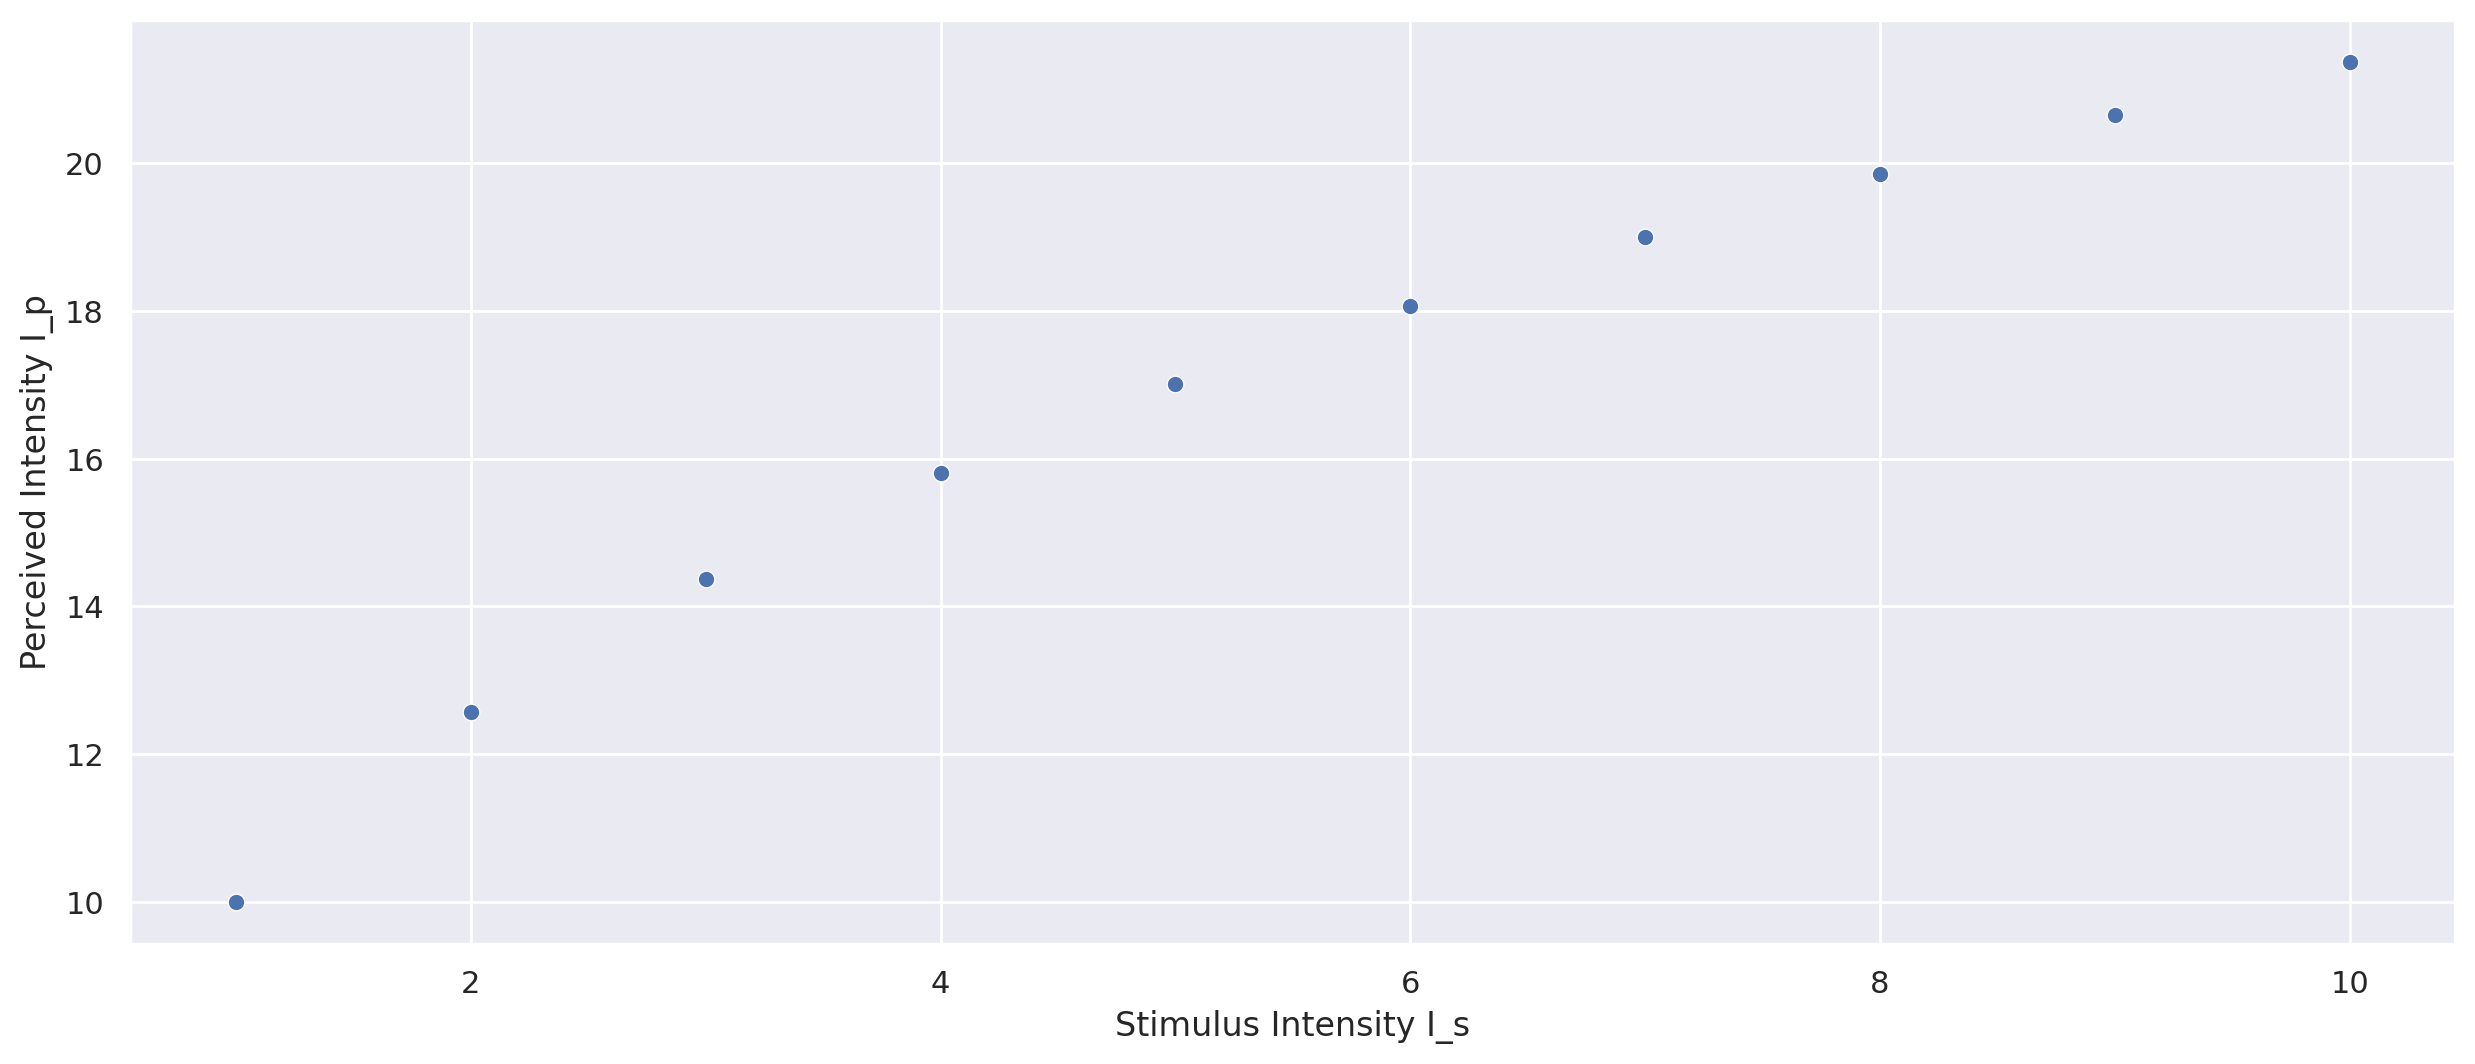

In [ ]:
fig, ax = plt.subplots()

# simulated observer
sns.scatterplot(y=I_p, x=I_s);

# fitted fechner
    

plt.ylabel("Perceived Intensity I_p")
plt.xlabel("Stimulus Intensity I_s")
plt.show()

### List the parameter values for Fechner's law

TypeError: only size-1 arrays can be converted to Python scalars

### Plot the simulated data and curve showing Fechner's law

### Evaluate whether Fechner's law provides a reasonable fit by visual inspection of the simulated data and the model

### For electric shock, Stevens found the exponent to be approximately $a=3.3>1$. As before, calculate the perceived stimulus intensity for physical intensities $I_s=1,2, \ldots, 10$ using Stevens' law and fit Fechner's law to the simulated data.

In [ ]:
# what a value is a good fit for the data? Is 3.3 good enough?

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7393f88e-6674-4a74-8a6c-ce9dc44581ca' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>